<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/MLP(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Multi-Layer Perceptron for Agricultural Production Classification with Epoch Training (3 Labels)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, classification_report, confusion_matrix, log_loss)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [27]:


# Step 1: Load the datasets
print("Step 1: Loading datasets...")
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    validation_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')
    print(f"Train dataset shape: {train_df.shape}")
    print(f"Validation dataset shape: {validation_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")

Step 1: Loading datasets...
Train dataset shape: (3942, 84)
Validation dataset shape: (845, 84)
Test dataset shape: (845, 84)


In [28]:


# Step 2: Data preprocessing and label creation (3 categories)
print("\nStep 2: Data preprocessing and label creation (3 categories)...")

def create_production_labels_3class(df):
    """Create low, medium, high labels based on tertiles (33rd and 67th percentiles)"""
    production_col = 'Production (M.Ton)'

    # Calculate tertiles (33rd and 67th percentiles)
    q33 = df[production_col].quantile(0.33)
    q67 = df[production_col].quantile(0.67)

    print(f"Tertile boundaries:")
    print(f"Low: <{q33:.2f}")
    print(f"Medium: {q33:.2f}-{q67:.2f}")
    print(f"High: >{q67:.2f}")

    # Create labels
    labels = []
    for value in df[production_col]:
        if value <= q33:
            labels.append('low')
        elif value <= q67:
            labels.append('medium')
        else:
            labels.append('high')

    return labels, q33, q67

# Create labels for training data
train_labels, q33, q67 = create_production_labels_3class(train_df)
train_df['production_category'] = train_labels

# Apply same tertile boundaries to validation and test sets
def apply_tertile_labels(df, q33, q67):
    production_col = 'Production (M.Ton)'
    labels = []
    for value in df[production_col]:
        if value <= q33:
            labels.append('low')
        elif value <= q67:
            labels.append('medium')
        else:
            labels.append('high')
    return labels

validation_df['production_category'] = apply_tertile_labels(validation_df, q33, q67)
test_df['production_category'] = apply_tertile_labels(test_df, q33, q67)

# Check label distribution
print("\nLabel distribution:")
print("Training set:")
print(train_df['production_category'].value_counts().sort_index())
print("\nValidation set:")
print(validation_df['production_category'].value_counts().sort_index())
print("\nTest set:")
print(test_df['production_category'].value_counts().sort_index())


Step 2: Data preprocessing and label creation (3 categories)...
Tertile boundaries:
Low: <1071.56
Medium: 1071.56-4035.91
High: >4035.91

Label distribution:
Training set:
production_category
high      1301
low       1301
medium    1340
Name: count, dtype: int64

Validation set:
production_category
high      270
low       278
medium    297
Name: count, dtype: int64

Test set:
production_category
high      291
low       274
medium    280
Name: count, dtype: int64


In [29]:


# Step 3: Feature preparation
print("\nStep 3: Feature preparation...")

def prepare_features(df):
    """Prepare features by dropping the target and production columns"""
    features = df.drop(['Production (M.Ton)', 'production_category'], axis=1)
    return features

X_train = prepare_features(train_df)
y_train = train_df['production_category']

X_val = prepare_features(validation_df)
y_val = validation_df['production_category']

X_test = prepare_features(test_df)
y_test = test_df['production_category']

print(f"Feature dimensions: {X_train.shape[1]} features")
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")


Step 3: Feature preparation...
Feature dimensions: 83 features
Training features shape: (3942, 83)
Validation features shape: (845, 83)
Test features shape: (845, 83)


In [30]:
# Step 4: Feature scaling
print("\nStep 4: Feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Step 4: Feature scaling...


In [31]:
# Step 5: Label encoding
print("\nStep 5: Label encoding...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Step 5: Label encoding...
Label mapping: {'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2)}


In [32]:
# Step 6: Build MLP model with epoch-based training (adjusted for 3 classes)
print("\nStep 6: Building MLP model for epoch-based training (3 classes)...")

def train_mlp_with_epochs(X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """Train MLP with epoch-by-epoch tracking and early stopping"""
    mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),  # Slightly smaller network for 3 classes
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=batch_size,
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=1,
        shuffle=True,
        random_state=42,
        warm_start=True,
        tol=1e-8,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8
    )

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0
    best_val_epoch = 0

    # Early stopping parameters
    patience = 10
    min_delta = 0.001
    early_stop_counter = 0
    best_val_loss = np.inf

    print(f"\nStarting training for {epochs} epochs...")
    print("="*80)

    for epoch in range(epochs):
        mlp.fit(X_train, y_train)

        train_pred = mlp.predict(X_train)
        val_pred = mlp.predict(X_val)
        train_pred_proba = mlp.predict_proba(X_train)
        val_pred_proba = mlp.predict_proba(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_epoch = epoch + 1

        n_classes = len(np.unique(y_train))
        y_train_onehot = np.eye(n_classes)[y_train]
        y_val_onehot = np.eye(n_classes)[y_val]

        train_loss = log_loss(y_train_onehot, train_pred_proba)
        val_loss = log_loss(y_val_onehot, val_pred_proba)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print("="*80)
    print("Training completed!")

    return mlp, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc,
        'best_val_epoch': best_val_epoch
    }

# Train the model with epoch tracking and early stopping
print("\nTraining MLP with epoch-based monitoring (3 classes)...")
epochs = 150
mlp, training_history = train_mlp_with_epochs(
    X_train_scaled, y_train_encoded,
    X_val_scaled, y_val_encoded,
    epochs=epochs, batch_size=32
)


Step 6: Building MLP model for epoch-based training (3 classes)...

Training MLP with epoch-based monitoring (3 classes)...

Starting training for 150 epochs...
Epoch  10/150 | Train Loss: 0.1219 | Val Loss: 0.3093 | Train Acc: 0.9543 | Val Acc: 0.8923
Epoch  20/150 | Train Loss: 0.0844 | Val Loss: 0.3430 | Train Acc: 0.9678 | Val Acc: 0.8982
Early stopping triggered at epoch 22
Training completed!


In [33]:


# Step 7: Make final predictions
print("\nStep 7: Making final predictions...")
y_train_pred = mlp.predict(X_train_scaled)
y_val_pred = mlp.predict(X_val_scaled)
y_test_pred = mlp.predict(X_test_scaled)


Step 7: Making final predictions...


In [34]:
# Step 8: Calculate final metrics
print("\nStep 8: Calculating final classification metrics...")

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate all classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"\n{dataset_name} Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train_encoded, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val_encoded, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test_encoded, y_test_pred, "Test")


Step 8: Calculating final classification metrics...

Training Classification Metrics:
Accuracy: 0.9668
Precision (Macro): 0.9668
Recall (Macro): 0.9669
F1 Score (Macro): 0.9669
F1 Score (Weighted): 0.9667

Validation Classification Metrics:
Accuracy: 0.8947
Precision (Macro): 0.8955
Recall (Macro): 0.8953
F1 Score (Macro): 0.8953
F1 Score (Weighted): 0.8946

Test Classification Metrics:
Accuracy: 0.9195
Precision (Macro): 0.9205
Recall (Macro): 0.9199
F1 Score (Macro): 0.9199
F1 Score (Weighted): 0.9198


In [35]:
# Step 9: Detailed classification report
print("\nStep 9: Detailed classification reports...")

def print_classification_report(y_true, y_pred, dataset_name, label_encoder):
    """Print detailed classification report"""
    print(f"\n{dataset_name} Classification Report:")
    target_names = label_encoder.classes_
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)

print_classification_report(y_val_encoded, y_val_pred, "Validation", label_encoder)
print_classification_report(y_test_encoded, y_test_pred, "Test", label_encoder)


Step 9: Detailed classification reports...

Validation Classification Report:
              precision    recall  f1-score   support

        high       0.89      0.88      0.89       270
         low       0.94      0.95      0.94       278
      medium       0.86      0.86      0.86       297

    accuracy                           0.89       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.89      0.89      0.89       845


Test Classification Report:
              precision    recall  f1-score   support

        high       0.95      0.91      0.93       291
         low       0.95      0.95      0.95       274
      medium       0.87      0.90      0.88       280

    accuracy                           0.92       845
   macro avg       0.92      0.92      0.92       845
weighted avg       0.92      0.92      0.92       845




Step 10: Creating individual training history plots...
Creating Figure 1: Training and Validation Loss


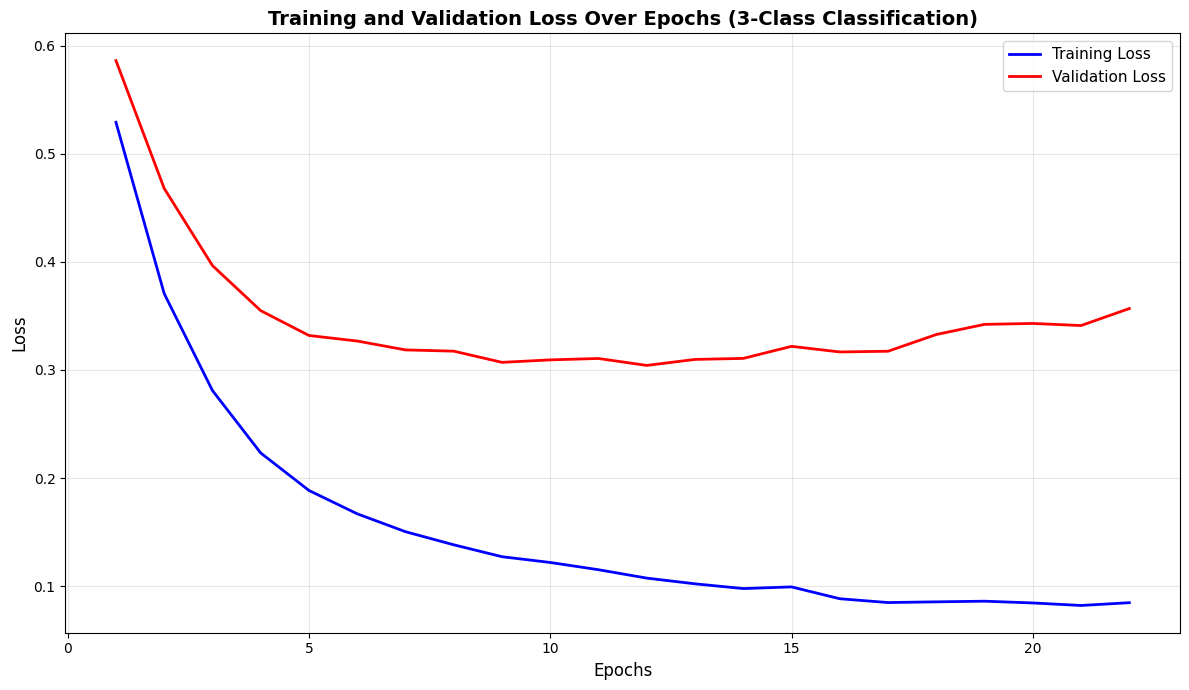

Creating Figure 2: Training and Validation Accuracy


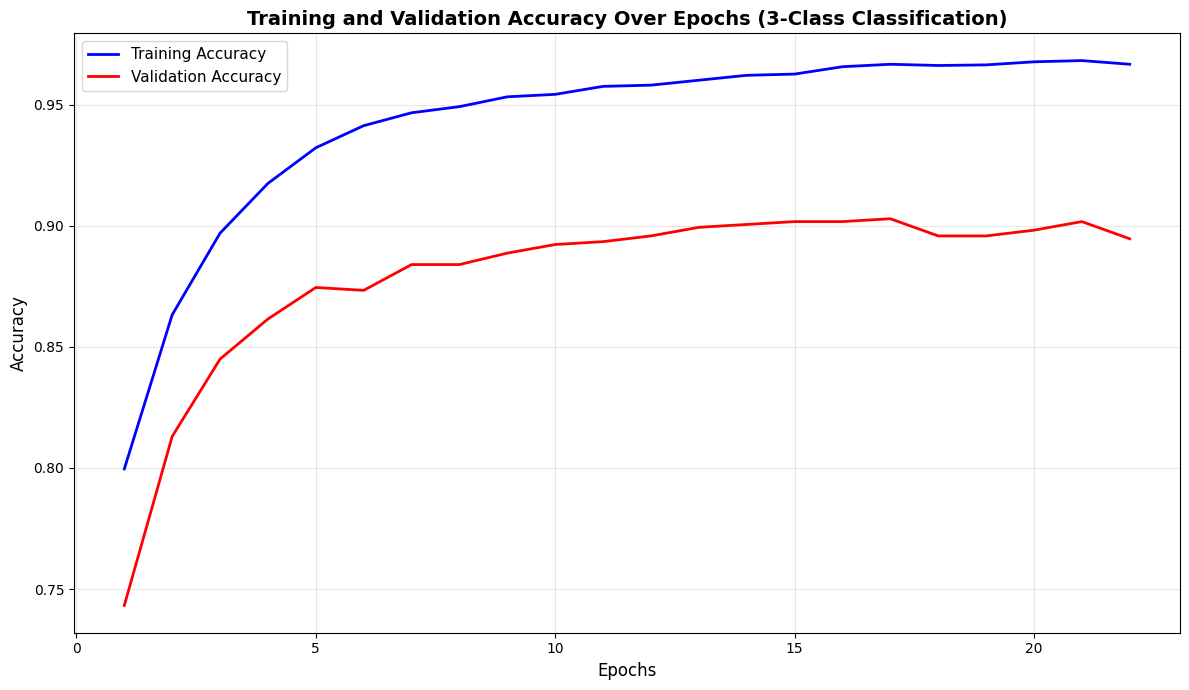

In [36]:


# Step 10: Plot training history over epochs (Individual Figures)
print("\nStep 10: Creating individual training history plots...")

epochs_range = range(1, len(training_history['train_losses']) + 1)

# Figure 1: Training and Validation Loss
print("Creating Figure 1: Training and Validation Loss")
plt.figure(figsize=(12, 7))
plt.plot(epochs_range, training_history['train_losses'], 'b-', linewidth=2, label='Training Loss')
plt.plot(epochs_range, training_history['val_losses'], 'r-', linewidth=2, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (3-Class Classification)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Training and Validation Accuracy
print("Creating Figure 2: Training and Validation Accuracy")
plt.figure(figsize=(12, 7))
plt.plot(epochs_range, training_history['train_accuracies'], 'b-', linewidth=2, label='Training Accuracy')
plt.plot(epochs_range, training_history['val_accuracies'], 'r-', linewidth=2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs (3-Class Classification)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Step 11: Creating individual confusion matrix plots...
Creating Figure 3: Training Confusion Matrix


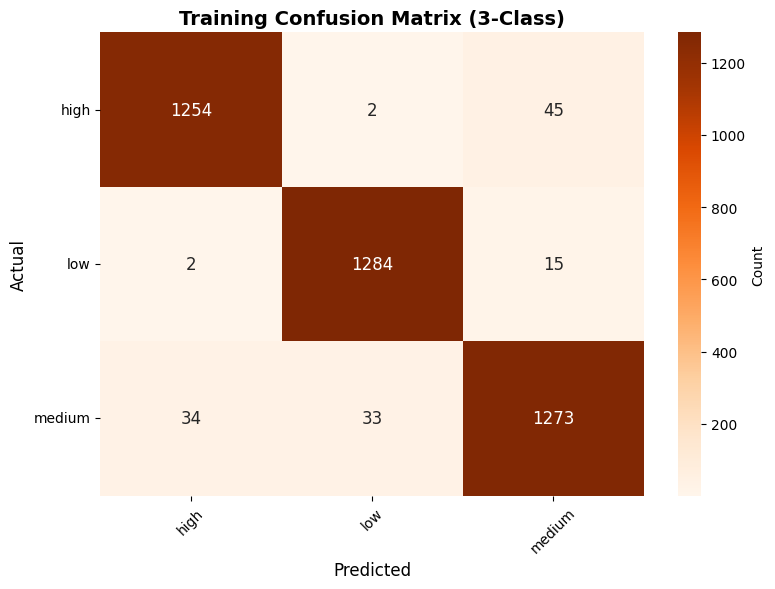

Creating Figure 4: Validation Confusion Matrix


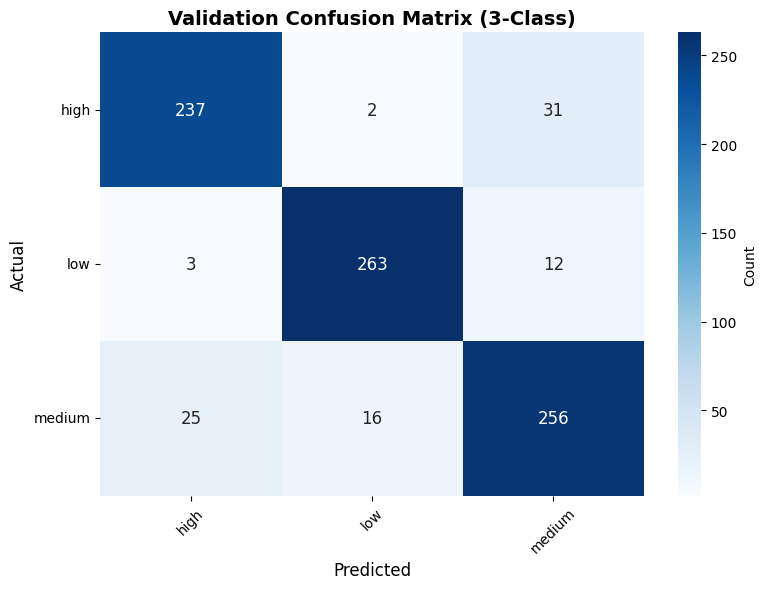

Creating Figure 5: Test Confusion Matrix


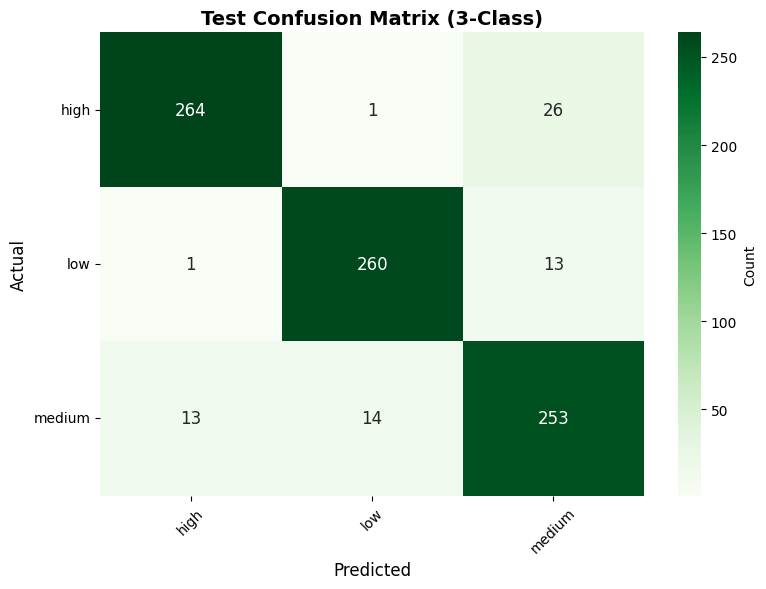

In [37]:


# Step 11: Individual confusion matrices (3x3 matrices)
print("\nStep 11: Creating individual confusion matrix plots...")

# Figure 3: Training Confusion Matrix
print("Creating Figure 3: Training Confusion Matrix")
plt.figure(figsize=(8, 6))
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 12})
plt.title('Training Confusion Matrix (3-Class)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Figure 4: Validation Confusion Matrix
print("Creating Figure 4: Validation Confusion Matrix")
plt.figure(figsize=(8, 6))
cm_val = confusion_matrix(y_val_encoded, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 12})
plt.title('Validation Confusion Matrix (3-Class)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Figure 5: Test Confusion Matrix
print("Creating Figure 5: Test Confusion Matrix")
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 12})
plt.title('Test Confusion Matrix (3-Class)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



Step 12: Creating class distribution plots...


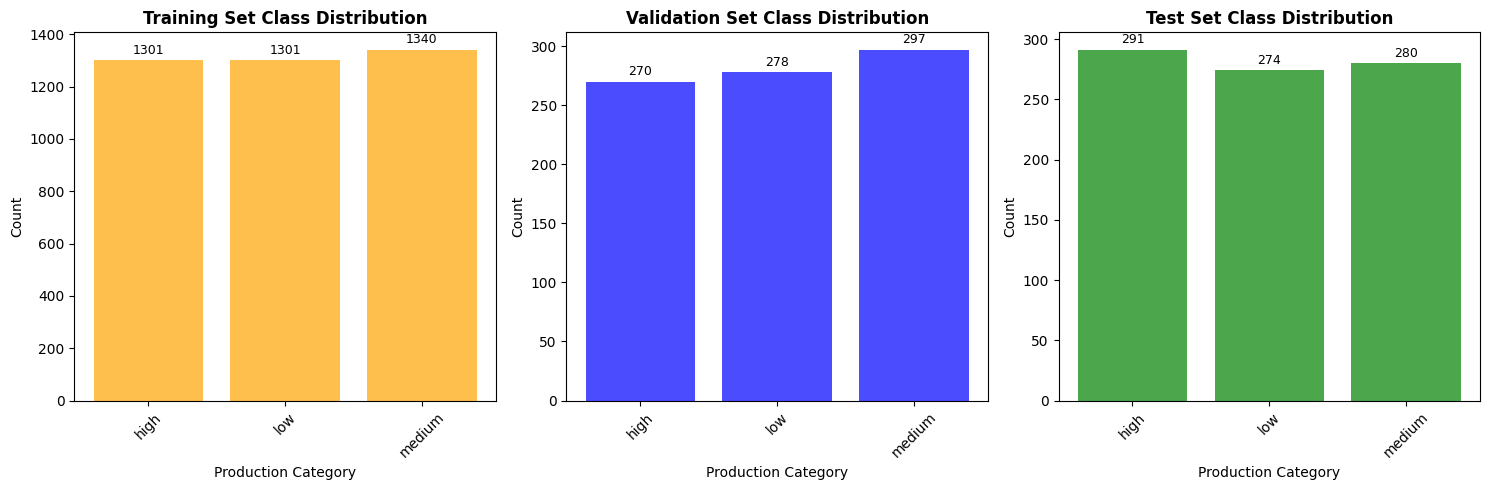

In [38]:

# Step 12: Class distribution visualization
print("\nStep 12: Creating class distribution plots...")

# Plot class distributions across datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [train_df, validation_df, test_df]
dataset_names = ['Training', 'Validation', 'Test']
colors = ['orange', 'blue', 'green']

for i, (df, name, color) in enumerate(zip(datasets, dataset_names, colors)):
    class_counts = df['production_category'].value_counts().sort_index()
    axes[i].bar(class_counts.index, class_counts.values, color=color, alpha=0.7)
    axes[i].set_title(f'{name} Set Class Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Production Category', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for j, v in enumerate(class_counts.values):
        axes[i].text(j, v + max(class_counts.values) * 0.01, str(v),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [39]:

# Step 13: Summary metrics table
print("\nStep 13: Final summary metrics table...")

# Create summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']],
    'Precision (Macro)': [train_metrics['precision_macro'], val_metrics['precision_macro'], test_metrics['precision_macro']],
    'Recall (Macro)': [train_metrics['recall_macro'], val_metrics['recall_macro'], test_metrics['recall_macro']],
    'F1 Score (Macro)': [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']],
    'F1 Score (Weighted)': [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']]
}

summary_df = pd.DataFrame(summary_data)
print("\nFinal Classification Metrics Summary (3-Class):")
print(summary_df.round(4))


Step 13: Final summary metrics table...

Final Classification Metrics Summary (3-Class):
      Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  \
0    Training    0.9668             0.9668          0.9669            0.9669   
1  Validation    0.8947             0.8955          0.8953            0.8953   
2        Test    0.9195             0.9205          0.9199            0.9199   

   F1 Score (Weighted)  
0               0.9667  
1               0.8946  
2               0.9198  


In [40]:


# Step 14: Model information
print("\nStep 14: Final model information...")
print(f"Model architecture: {mlp.hidden_layer_sizes}")
print(f"Total epochs trained: {epochs}")
print(f"Final training loss: {training_history['train_losses'][-1]:.6f}")
print(f"Final validation loss: {training_history['val_losses'][-1]:.6f}")
print(f"Best validation accuracy: {training_history['best_val_acc']:.4f} (Epoch {training_history['best_val_epoch']})")

# Training convergence analysis
print(f"\nTraining Convergence Analysis:")
final_10_train_loss = np.mean(training_history['train_losses'][-10:])
final_10_val_loss = np.mean(training_history['val_losses'][-10:])
print(f"Average loss in final 10 epochs - Train: {final_10_train_loss:.4f}, Val: {final_10_val_loss:.4f}")

loss_improvement = training_history['train_losses'][0] - training_history['train_losses'][-1]
print(f"Total training loss improvement: {loss_improvement:.4f}")

# Additional analysis for 3-class problem
print(f"\n3-Class Classification Analysis:")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Class labels: {list(label_encoder.classes_)}")

# Per-class accuracy analysis
def calculate_per_class_accuracy(y_true, y_pred, label_encoder):
    """Calculate per-class accuracy"""
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"{class_name}: {per_class_acc[i]:.4f}")

    return per_class_acc

print("\nTest Set Per-Class Analysis:")
test_per_class_acc = calculate_per_class_accuracy(y_test_encoded, y_test_pred, label_encoder)

print("\n" + "="*80)
print("3-CLASS EPOCH-BASED MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)


Step 14: Final model information...
Model architecture: (128, 64, 32)
Total epochs trained: 150
Final training loss: 0.084674
Final validation loss: 0.356761
Best validation accuracy: 0.9030 (Epoch 17)

Training Convergence Analysis:
Average loss in final 10 epochs - Train: 0.0895, Val: 0.3292
Total training loss improvement: 0.4444

3-Class Classification Analysis:
Number of classes: 3
Class labels: ['high', 'low', 'medium']

Test Set Per-Class Analysis:

Per-class Accuracy:
high: 0.9072
low: 0.9489
medium: 0.9036

3-CLASS EPOCH-BASED MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
